LDA topic model for content in each category

source: https://developer.ibm.com/tutorials/awb-lda-topic-modeling-text-analysis-python/

explaination: https://www.casact.org/sites/default/files/2023-04/iCAS-4_Latent_Dirichlet_Allocation_Topic_Modeling_in_Python.pdf?utm_source=chatgpt.com

In [1]:
!pip install nltk==3.9.1

In [ ]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models as gensimvisualize
from collections import defaultdict, Counter
import numpy as np
from sklearn.manifold import TSNE
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/beenayaknon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

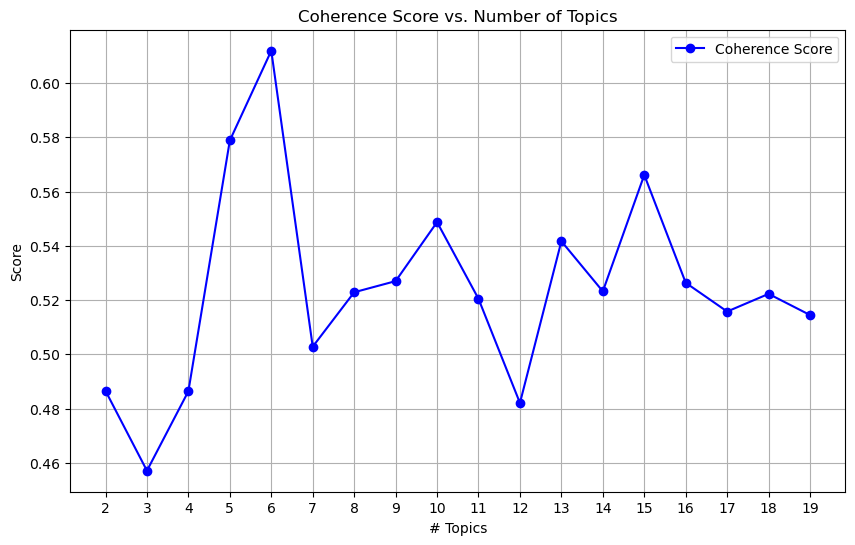

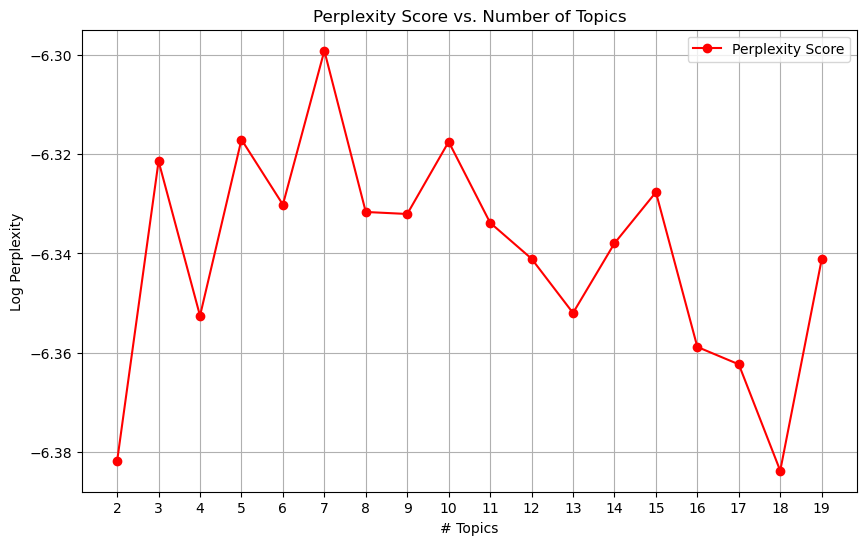

In [ ]:
# Find best number of topics based on coherence and perplexity scores
data = pd.read_csv('dataset/category_with_document.csv')

data['processed_Document'] = data['Document'].apply(preprocess_text)
texts = data['processed_Document'].tolist()

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=2)
corpus = [dictionary.doc2bow(text) for text in texts]

num_topics_list = range(2, 20)
coherence_scores = []
perplexity_scores = []

# Train models and calculate coherence and perplexity scores
for num_topics in num_topics_list:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, random_state=63,
                         chunksize=20, num_topics=num_topics, passes=100, iterations=200, eta=0.5)
    
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

    # Compute Perplexity Score
    perplexity_scores.append(lda_model.log_perplexity(corpus))

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o', label='Coherence Score', color='b')
plt.xlabel('# Topics')
plt.ylabel('Score')
plt.title('Coherence Score vs. Number of Topics')
plt.xticks(num_topics_list)
plt.grid()
plt.legend()
plt.show()

# Plot the perplexity scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, perplexity_scores, marker='o', label='Perplexity Score', color='r')
plt.xlabel('# Topics')
plt.ylabel('Log Perplexity')
plt.title('Perplexity Score vs. Number of Topics')
plt.xticks(num_topics_list)
plt.grid()
plt.legend()
plt.show()


In [4]:
# LDA modeling for all documents
data = pd.read_csv('dataset/category_with_document.csv')

data['processed_Document'] = data['Document'].apply(preprocess_text)
texts = data['processed_Document'].tolist()

# load dictionary
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below = 2)

# words to be procedd
total_words = sum(len(text) for text in texts)
print("Total words after preprocessing:", total_words)
unique_words = len(dictionary)
print("Unique words after filtering:", unique_words)


# generate corpus as BoW
corpus = [dictionary.doc2bow(text) for text in texts]

# train LDA model
num_topics=6
lda_model = LdaModel(corpus=corpus, id2word=dictionary, chunksize=20, num_topics=num_topics, passes=100, iterations=200, random_state=63, eta=0.5)

for topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(topic)

coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print('Coherence:', coherence_score)

perplexity_score = lda_model.log_perplexity(corpus)
print('Perplexity:', perplexity_score)

Total words after preprocessing: 23372
Unique words after filtering: 1606
(0, '0.050*"issue" + 0.028*"report" + 0.026*"advisory" + 0.018*"fix" + 0.017*"maintainer" + 0.017*"github" + 0.014*"project" + 0.013*"cve" + 0.013*"may" + 0.013*"click"')
(1, '0.023*"model" + 0.016*"data" + 0.015*"code" + 0.014*"using" + 0.011*"pytorch" + 0.011*"untrusted" + 0.008*"run" + 0.007*"build" + 0.007*"developer" + 0.007*"secure"')
(2, '0.037*"issue" + 0.023*"please" + 0.017*"key" + 0.015*"report" + 0.014*"code" + 0.012*"source" + 0.012*"bounty" + 0.011*"possible" + 0.011*"pgp" + 0.011*"program"')
(3, '0.121*"version" + 0.084*"supported" + 0.076*"policy" + 0.040*"release" + 0.028*"whitecheckmark" + 0.023*"latest" + 0.020*"update" + 0.017*"support" + 0.013*"project" + 0.012*"currently"')
(4, '0.019*"spark" + 0.016*"file" + 0.013*"access" + 0.012*"application" + 0.012*"user" + 0.011*"tdtd" + 0.010*"secret" + 0.008*"authentication" + 0.008*"table" + 0.008*"license"')
(5, '0.086*"vulnerability" + 0.044*"repo

In [ ]:
# Topics visualization
# Get topic distributions for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Convert topic distributions to a matrix
topic_matrix = np.zeros((len(topic_distributions), num_topics))
for i, dist in enumerate(topic_distributions):
    for topic_num, prob in dist:
        topic_matrix[i, topic_num] = prob

# Perform t-SNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_values = tsne_model.fit_transform(topic_matrix)

# Get the dominant topic for each document
dominant_topics = np.argmax(topic_matrix, axis=1)

# Create a DataFrame to store t-SNE values and dominant topics
tsne_df = pd.DataFrame(tsne_values, columns=['x', 'y'])
tsne_df['topic'] = dominant_topics

# Plot the t-SNE results with topic labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['topic'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Topic')
plt.title('t-SNE Clustering of LDA Topics')

plt.show()

# Print the topics and their corresponding colors
for topic in range(num_topics):
    terms = [term for term, _ in lda_model.show_topic(topic, topn=10)]
    print(f"Topic {topic}: " + ", ".join(terms) + f" (Color: {scatter.cmap(scatter.norm(topic))})")

In [ ]:
# Top 10 most relevance terms in each topics
# visualization
dickens_visual = gensimvisualize.prepare(lda_model, corpus, dictionary, mds='mmds')
# pyLDAvis.display(dickens_visual)

topic_info = dickens_visual.topic_info
topic_terms = topic_info.groupby('Category')

category_term_counts = {topic: Counter() for topic in topic_terms.groups}
category_term_details = {topic: {} for topic in topic_terms.groups}

for topic, group in topic_terms:
    print(f"Topic {topic}:")
    sorted_words = group.sort_values(by='Freq', ascending=False)
    top_words = sorted_words[['Term', 'Freq']].head(10)
    for word, freq in zip(top_words['Term'], top_words['Freq']):
        print(f"  {word} ({freq:.2f})")
    print("\n")

top_terms_per_topic = {}

for topic, group in topic_terms:
    sorted_words = group.sort_values(by='Freq', ascending=False)
    top_terms = sorted_words[['Term', 'Freq']].head(10)
    top_terms_per_topic[topic] = set(top_terms['Term'])

Topic Default:
  vulnerability (622.00)
  issue (448.00)
  report (415.00)
  please (343.00)
  version (262.00)
  reporting (259.00)
  policy (206.00)
  supported (183.00)
  email (148.00)
  project (138.00)


Topic Topic1:
  vulnerability (604.31)
  report (311.50)
  please (263.06)
  issue (240.11)
  reporting (231.82)
  email (120.89)
  bug (93.18)
  public (88.01)
  disclosure (78.77)
  team (78.13)


Topic Topic2:
  spark (54.10)
  file (45.07)
  access (36.88)
  application (34.89)
  user (34.42)
  tdtd (29.84)
  secret (29.64)
  authentication (23.76)
  table (23.45)
  license (22.93)


Topic Topic3:
  model (62.40)
  data (43.81)
  code (40.57)
  using (39.77)
  pytorch (30.33)
  untrusted (30.19)
  run (20.66)
  build (19.49)
  developer (19.22)
  secure (18.62)


Topic Topic4:
  issue (123.70)
  report (69.46)
  advisory (64.26)
  fix (45.33)
  maintainer (43.28)
  github (42.31)
  project (36.19)
  cve (32.50)
  may (31.73)
  click (31.38)


Topic Topic5:
  issue (83.27)
  p

In [7]:
# Count terms occurance in each category
data = pd.read_csv('sampled_4_category_with_document.csv')
data['processed_Document'] = data['Document'].apply(preprocess_text)

topic_terms = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
top_terms_per_topic = {topic: [term for term, _ in words] for topic, words in topic_terms}

# count term occurrences in each category
category_term_counts = defaultdict(Counter)
category_term_details = defaultdict(lambda: defaultdict(Counter))

# Identify terms that appear in multiple topics
term_topic_mapping = defaultdict(set)
for topic, terms in top_terms_per_topic.items():
    for term in terms:
        term_topic_mapping[term].add(topic)
multi_topic_terms = {term: topics for term, topics in term_topic_mapping.items() if len(topics) > 1}

print("Multi-topic terms:")
for term, topics in multi_topic_terms.items():
    print(f"{term}: Topics {sorted(topics)}")

multi_topic_term_category_counts = defaultdict(lambda: defaultdict(int))

# Count occurrences of multi-topic terms per category
for term, topics in multi_topic_terms.items():
    for _, row in data.iterrows():
        category = row['Category']
        document_content = str(row['processed_Document']).lower()
        count = document_content.count(term)

        if count > 0:
            multi_topic_term_category_counts[term][category] += count

# Count occurrences only for non-multi-topic terms
for topic, top_terms in top_terms_per_topic.items():
    single_topic = [term for term in top_terms if term not in multi_topic_terms]
    for _, row in data.iterrows():
        category = row['Category']
        document_content = str(row['processed_Document']).lower()

        term_counts = {term: document_content.count(term) for term in single_topic}
        total_count = sum(term_counts.values())

        category_term_counts[topic][category] += total_count

        if category not in category_term_details[topic]:
            category_term_details[topic][category] = Counter()
        category_term_details[topic][category].update(term_counts)


multi_topic_term_df = pd.DataFrame(multi_topic_term_category_counts).T.fillna(0)
multi_topic_term_df['Topics'] = multi_topic_term_df.index.map(lambda term: sorted(multi_topic_terms[term]))

# most occurrences for each topic
topic_category_analysis = {
    topic: {
        "Category": category_counts.most_common(1)[0][0] if category_counts else "None",
        "Occurrences": category_counts.most_common(1)[0][1] if category_counts else 0,
        "Terms": category_term_details[topic][category_counts.most_common(1)[0][0]] if category_counts else {}
    }
    for topic, category_counts in category_term_counts.items()
}

print(multi_topic_terms)
display(multi_topic_term_df)
display(topic_category_analysis)

Multi-topic terms:
issue: Topics [0, 2, 5]
report: Topics [0, 2, 5]
project: Topics [0, 3]
code: Topics [1, 2]
please: Topics [2, 5]
{'issue': {0, 2, 5}, 'report': {0, 2, 5}, 'project': {0, 3}, 'code': {1, 2}, 'please': {2, 5}}


,Generic policy,Reporting mechanism,Scope of practise,User guideline,Topics
issue,24,170,6,41,"[0, 2, 5]"
report,35,267,1,24,"[0, 2, 5]"
project,40,39,17,10,"[0, 3]"
code,11,18,4,245,"[1, 2]"
please,9,103,8,23,"[2, 5]"


{0: {'Category': 'Reporting mechanism',
  'Occurrences': 177,
  'Terms': Counter({'advisory': 19,
           'fix': 33,
           'maintainer': 21,
           'github': 85,
           'cve': 2,
           'may': 11,
           'click': 6})},
 1: {'Category': 'User guideline',
  'Occurrences': 433,
  'Terms': Counter({'model': 115,
           'data': 45,
           'using': 59,
           'pytorch': 24,
           'untrusted': 49,
           'run': 67,
           'build': 21,
           'developer': 21,
           'secure': 32})},
 2: {'Category': 'User guideline',
  'Occurrences': 140,
  'Terms': Counter({'key': 68,
           'source': 30,
           'bounty': 10,
           'possible': 9,
           'pgp': 2,
           'program': 21})},
 3: {'Category': 'Scope of practise',
  'Occurrences': 913,
  'Terms': Counter({'version': 256,
           'supported': 185,
           'policy': 13,
           'release': 66,
           'whitecheckmark': 63,
           'latest': 44,
           'upd